In [180]:
import pandas as pd
from rxnmapper import RXNMapper
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [181]:
df = pd.read_csv('/home/ruard/code/virtual_reactions/data/datasets/da/da_no_solvent_dataset.csv')
df

,Unnamed: 0,reaction_idx,uid,substrates,products,reaction_smiles,labels,simulation_idx
0,0,2,0,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C=C(Br)C1C(OC)(OC)C2=O,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,0,0.0
1,1,2,1,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C(Br)=CC1C(=O)C2(OC)OC,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,1,0.0
2,2,6,2,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1CC=CC12,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,1,0.0
3,3,6,3,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C(Cl)=C(Cl)C2(Cl)C3C=CC(C3)C12Cl,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,0,0.0
4,4,7,4,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1,CCC(=O)C1CC=CC(NC(=O)OCc2ccccc2)C1,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1>>CCC(=O)C1CC...,0,0.0
...,...,...,...,...,...,...,...,...
1162,1162,1679,1162,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CCC1(C(F)(F)F)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CCC1(...,0,0.0
1163,1163,1679,1163,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,FC(F)(F)C(=CC1CC=CCC1)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>FC(F)(F)C(=CC...,1,0.0
1164,1164,1679,1164,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CC(C(F)(F)F)(C(F)(F)F)C1,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CC(C(...,0,0.0
1165,1165,1680,1165,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1,O=C1C=CC(=O)C2(Cl)C3C=CC(C3)C12Cl,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1>>O=C1C=CC(=O)...,0,0.0


## Obtaining reaction core minimal reactions for all DA reactions

In [184]:
rxn_mapper = RXNMapper()

da_rxn_smarts = AllChem.ReactionFromSmarts(
    '[#6:1]=[#6:2].[#6:3]=[#6:4][#6:5]=[#6:6]>>[#6:1]1[#6:2][#6:3][#6:4]=[#6:5][#6:6]1'
)

_bondtypes = {
    1: Chem.BondType.SINGLE,
    2: Chem.BondType.DOUBLE,
    3: Chem.BondType.AROMATIC
}

def simulate_da_reaction(substrates):
    products = []
    products += da_rxn_smarts.RunReactants(substrates)
    substrates = [substrates[1], substrates[0]]
    products += da_rxn_smarts.RunReactants(substrates)
    
    products = [Chem.MolToSmiles(product[0]) for product in products]
    products = list(set(products))
    return [Chem.MolFromSmiles(product) for product in products]

def get_core_reaction_from_smiles(reaction_smiles: str):
    reaction_smiles = rxn_mapper.get_attention_guided_atom_maps([reaction_smiles])[0]['mapped_rxn']
    rxn = Chem.rdChemReactions.ReactionFromSmarts(reaction_smiles, useSmiles=True)
    rxn.Initialize()
    
    product_mol = Chem.MolFromSmiles(reaction_smiles.split('>>')[1])
    
    reacting_atoms = rxn.GetReactingAtoms()
    if len(reacting_atoms[0]) == 2 and len(reacting_atoms[1]) == 4:
        reactants = reaction_smiles.split('>>')[0].split('.')
        dienophile_smiles, dienophile_idxs = reactants[0], reacting_atoms[0]
        diene_smiles, diene_idxs = reactants[1], reacting_atoms[1]
    elif len(reacting_atoms[0]) ==4 and len(reacting_atoms[1]) == 2:
        reactants = reaction_smiles.split('>>')[0].split('.')
        dienophile_smiles, dienophile_idxs = reactants[1], reacting_atoms[1]
        diene_smiles, diene_idxs = reactants[0], reacting_atoms[0]
    else:
#         print("couldnt extract diene + dienophile", reacting_atoms)
        return []
    
    # dienophile
    dienophile = Chem.AddHs(Chem.MolFromSmiles(dienophile_smiles))
    rdedmol = Chem.EditableMol(Chem.Mol())
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddBond(0, 1, _bondtypes[2])
    
    # get idxs & neighbors
    idxs = dienophile_idxs
    neighbors1 = list(dienophile.GetAtomWithIdx(idxs[0]).GetNeighbors())
    neighbors2 = list(dienophile.GetAtomWithIdx(idxs[1]).GetNeighbors())
    
    # remove neighbors that are part of diene group
    for idx in reversed(range(len(neighbors1))):
        atom = neighbors1[idx]
        if atom.GetIdx() == idxs[1]:
            neighbors1.pop(idx)
    for idx in reversed(range(len(neighbors2))):
        atom = neighbors2[idx]
        if atom.GetIdx() == idxs[0]:
            neighbors2.pop(idx)
    
    # add atoms that are both neighbors of each C atom
    for idx in list(set([a.GetIdx() for a in neighbors1]) & set([a.GetIdx() for a in neighbors2])):
        rdedmol.AddAtom(Chem.Atom(dienophile.GetAtomWithIdx(idx).GetAtomicNum()))
        rdedmol.AddBond(0, len(rdedmol.GetMol().GetAtoms()) - 1, _bondtypes[1])
        rdedmol.AddBond(1, len(rdedmol.GetMol().GetAtoms()) - 1, _bondtypes[1])
        
        for i in reversed(range(len(neighbors1))):
            atom = neighbors1[i]
            if atom.GetIdx() == idx:
                neighbors1.pop(i)
        for i in reversed(range(len(neighbors2))):
            atom = neighbors2[i]
            if atom.GetIdx() == idx:
                neighbors2.pop(i)
        
    # add leftover atoms
    for atom in neighbors1:
        bond_type = dienophile.GetBondBetweenAtoms(idxs[0], atom.GetIdx()).GetBondType()            
        rdedmol.AddAtom(Chem.Atom(atom.GetAtomicNum()))
        rdedmol.AddBond(0, len(rdedmol.GetMol().GetAtoms()) - 1, bond_type)
    for atom in neighbors2:
        bond_type = dienophile.GetBondBetweenAtoms(idxs[1], atom.GetIdx()).GetBondType()
        rdedmol.AddAtom(Chem.Atom(atom.GetAtomicNum()))
        rdedmol.AddBond(1, len(rdedmol.GetMol().GetAtoms()) - 1, bond_type)
    
    dienophile_mol = rdedmol.GetMol()
    try:
        Chem.SanitizeMol(dienophile_mol)
    except:
#         print("sanitization of dienophile failed")
        return []
    dienophile_smiles = Chem.MolToSmiles(dienophile_mol, isomericSmiles=True)
    
    # diene
    diene = Chem.AddHs(Chem.MolFromSmiles(diene_smiles))
    rdedmol = Chem.EditableMol(Chem.Mol())
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddBond(0, 1, _bondtypes[2])
    rdedmol.AddBond(1, 2, _bondtypes[1])
    rdedmol.AddBond(2, 3, _bondtypes[2])
    
    # get idxs & neighbors
    idxs = [diene_idxs[0], diene_idxs[3]]
    neighbors1 = list(diene.GetAtomWithIdx(idxs[0]).GetNeighbors())
    neighbors2 = list(diene.GetAtomWithIdx(idxs[1]).GetNeighbors())
    
    # remove neighbors that are part of diene group
    for idx in reversed(range(len(neighbors1))):
        atom = neighbors1[idx]
        if atom.GetIdx() == diene_idxs[1] or atom.GetIdx() == diene_idxs[2]:
            neighbors1.pop(idx)
    for idx in reversed(range(len(neighbors2))):
        atom = neighbors2[idx]
        if atom.GetIdx() == diene_idxs[1] or atom.GetIdx() == diene_idxs[2]:
            neighbors2.pop(idx)
    
    # add atoms that are both neighbors of each C atom
    for idx in list(set([a.GetIdx() for a in neighbors1]) & set([a.GetIdx() for a in neighbors2])):
        rdedmol.AddAtom(Chem.Atom(diene.GetAtomWithIdx(idx).GetAtomicNum()))
        rdedmol.AddBond(0, len(rdedmol.GetMol().GetAtoms()) - 1, _bondtypes[1])
        rdedmol.AddBond(3, len(rdedmol.GetMol().GetAtoms()) - 1, _bondtypes[1])
        
        for i in reversed(range(len(neighbors1))):
            atom = neighbors1[i]
            if atom.GetIdx() == idx:
                neighbors1.pop(i)
        for i in reversed(range(len(neighbors2))):
            atom = neighbors2[i]
            if atom.GetIdx() == idx:
                neighbors2.pop(i)
    
     # add leftover atoms
    for atom in neighbors1:
        bond_type = diene.GetBondBetweenAtoms(idxs[0], atom.GetIdx()).GetBondType()
        rdedmol.AddAtom(Chem.Atom(atom.GetAtomicNum()))
        rdedmol.AddBond(0, len(rdedmol.GetMol().GetAtoms()) - 1, bond_type)
    for atom in neighbors2:
        bond_type = diene.GetBondBetweenAtoms(idxs[1], atom.GetIdx()).GetBondType()
        rdedmol.AddAtom(Chem.Atom(atom.GetAtomicNum()))
        rdedmol.AddBond(3, len(rdedmol.GetMol().GetAtoms()) - 1, bond_type)
    
    
    diene_mol = rdedmol.GetMol()
    try:
        Chem.SanitizeMol(diene_mol)
    except:
#         print("sanitization of diene failed")
        return []
    diene_smiles = Chem.MolToSmiles(diene_mol, isomericSmiles=True)
    
    outputs = []
    products = simulate_da_reaction([dienophile_mol, diene_mol])
    products = list(set([Chem.MolToSmiles(product) for product in products]))
    
    if len(products) > 1:
        for product in products:
            if len(product_mol.GetSubstructMatches(Chem.MolFromSmiles(product))) >= 1:
                return [f"{diene_smiles}.{dienophile_smiles}>>{product}"]
#         print("no match between reaction core and product")
        return []
    elif len(products) == 1:
        return [f"{diene_smiles}.{dienophile_smiles}>>{products[0]}"] 
    else:
#         print("reaction generation of reaction core failed")
        return []

Some weights of the model checkpoint at /home/ruard/anaconda3/envs/ts/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [185]:
reaction_to_core_dict = {}

unmatched_reaction_smiles = []
for idx in range(len(df)):
    reaction_smiles = df['reaction_smiles'].values[idx]
    output = get_core_reaction_from_smiles(reaction_smiles)
    if len(output) == 0:
        unmatched_reaction_smiles.append(reaction_smiles)
    else:
        reaction_to_core_dict[reaction_smiles] = output[0]
            
# TODO: filter out double entries here using canonical SMILES
n_entries = len(reaction_to_core_dict.keys())
for i in range(1, n_entries):
    for j in range(i):
        try:
            smiles1 = list(reaction_to_core_dict.values())[i].split('>>')[-1]
            smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles1))
            smiles2 = list(reaction_to_core_dict.values())[j].split('>>')[-1]
            smiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles2))
        except:
            continue
        
        if smiles1 == smiles2:
            rxn_smiles = list(reaction_to_core_dict.values())[i]
            new_product = list(reaction_to_core_dict.values())[j].split('>>')[-1]
            reaction_to_core_dict[list(reaction_to_core_dict.keys())[i]] = f"{rxn_smiles.split('>>')[0]}>>{new_product}"
            
reaction_cores = list(set([v for k, v in reaction_to_core_dict.items()]))

print(len(reaction_cores))
print(len(unmatched_reaction_smiles))

172
478


In [186]:
new_df = df[~df['reaction_smiles'].isin(unmatched_reaction_smiles)]
print(len(new_df))

689


In [179]:
# with open('/home/ruard/Downloads/da_reaction_cores_new_new.txt', 'w') as f:
#     f.writelines('\n'.join(reaction_cores))

In [187]:
with open('/home/ruard/Downloads/succesfull_da_reaction_cores_new_new.txt', 'r') as f:
    reaction_core_smiles_list = [line.replace('\n', '') for line in f.readlines()]
    
reaction_smiles_list = []
for k, v in reaction_to_core_dict.items():
    if v in reaction_core_smiles_list:
        reaction_smiles_list.append(k)
        
new_df = df[df['reaction_smiles'].isin(reaction_smiles_list)]
print(len(new_df))
new_df.to_csv('/home/ruard/Downloads/test_da_reactions_new_new.csv')

640


In [160]:
unmatched_reaction_smiles

['C=CC(=O)OCC.C=CC(=C)C>>CCOC(=O)C1CCC=C(C)C1',
 'C=CC(=O)OCC.C=CC(=C)C>>CCOC(=O)C1CC=C(C)CC1',
 'C=CC1=CCc2ccccc21.CC1=CC2(C=CC1=O)OCCO2>>CC12CC=C3c4ccccc4CC3C1C1(C=CC2=O)OCCO1',
 'C1=CCCC=C1.O=C1C=CC(=O)C(F)=C1F>>O=C1C(F)=C(F)C(=O)C2C3C=CC(CC3)C12',
 'C1=CCCC=C1.O=C1C=CC(=O)C(F)=C1F>>O=C1C=CC(=O)C2(F)C3C=CC(CC3)C12F',
 'O=C1C=CCC1.C=CC1=CCC2CC1C2(C)C>>CC1(C)C2CC3C(=CCC4C(=O)CCC43)C1C2',
 'O=C1C=CCC1.C=CC1=CCC2CC1C2(C)C>>CC1(C)C2CC3C(=CCC4CCC(=O)C43)C1C2',
 'C=CC1=CCCCC1O.C=CC(=O)OC>>COC(=O)C1CC=C2C(O)CCCC2C1',
 'O=C1C=CCC1.C=CC=CC>>CC1C=CCC2C(=O)CCC12',
 'O=C1C=CCC1.C=CC=CC>>CC1C=CCC2CCC(=O)C12',
 'CN1C(=O)C=CC1=O.C=CC(=C)C(=C)C(=C)C=C>>C=CC(=C)C1=C(C=C)CC2C(=O)N(C)C(=O)C2C1',
 'CN1C(=O)C=CC1=O.C=CC(=C)C(=C)C(=C)C=C>>C=CC(=C)C(=C)C1=CCC2C(=O)N(C)C(=O)C2C1',
 'CC1(C)OC(=O)C(=Cc2ccc(Cl)cc2)C(=O)O1.C=CC(=C)C>>CC1=CCC2(C(=O)OC(C)(C)OC2=O)C(c2ccc(Cl)cc2)C1',
 'CC1(C)OC(=O)C(=Cc2ccc(Cl)cc2)C(=O)O1.C=CC(=C)C>>CC1=CCC(c2ccc(Cl)cc2)C2(C1)C(=O)OC(C)(C)OC2=O',
 'C=Cc1ccc(Cl)cc1.CC(C)(C)C1=CC(=O

In [165]:
get_core_reaction_from_smiles(unmatched_reaction_smiles[0])

couldnt extract diene + dienophile ((0, 1, 2, 3, 4), (5, 6))


[]

## Check quick if reaction core retrieval works

['C', 'H']
['C', 'H']
['C', 'H']
['C', 'H']


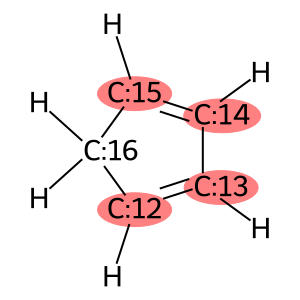

In [143]:
reaction_smiles = df['reaction_smiles'].values[3]

reaction_smiles = rxn_mapper.get_attention_guided_atom_maps([reaction_smiles])[0]['mapped_rxn']
rxn = Chem.rdChemReactions.ReactionFromSmarts(reaction_smiles, useSmiles=True)
rxn.Initialize()

reacting_atoms = rxn.GetReactingAtoms()


reactants = reaction_smiles.split('>>')[0].split('.')
reactants = [Chem.MolFromSmiles(smi) for smi in reactants]
reactants = [Chem.AddHs(reactant) for reactant in reactants]

for idx in rxn.GetReactingAtoms()[0]:
    neighbors = reactants[0].GetAtomWithIdx(idx).GetNeighbors()
    neighbors = [neighbor.GetSymbol() for neighbor in neighbors]
    neighbors.remove('C')
    print(neighbors)

img = Draw.MolToImage(reactants[0], highlightAtoms=rxn.GetReactingAtoms()[0])
img

['Cl', 'C']


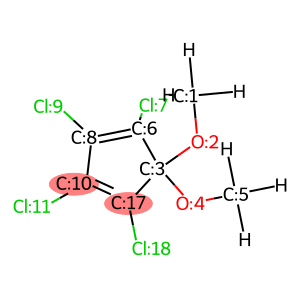

In [144]:
for i, idx in enumerate(rxn.GetReactingAtoms()[1]):
    if i == 0 or i == 3:
        neighbors = reactants[1].GetAtomWithIdx(idx).GetNeighbors()
        neighbors = [neighbor.GetSymbol() for neighbor in neighbors]
        neighbors.remove('C')
        print(neighbors)

img = Draw.MolToImage(reactants[1], highlightAtoms=rxn.GetReactingAtoms()[1])
img

### Check pipeline again

In [88]:
out = get_core_reaction_from_smiles(
    "C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(OC)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1CC=CC12"
)
out

('ClC1=CC=C(Cl)C1.[H]C(C)=C([H])C',
 'ClC1=CC=C(Cl)C1.[H]C(C)=C([H])C>>CC1C(C)C2(Cl)C=CC1(Cl)C2')

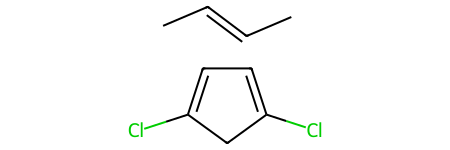

In [89]:
Chem.MolFromSmiles(out[1].split('>>')[0])

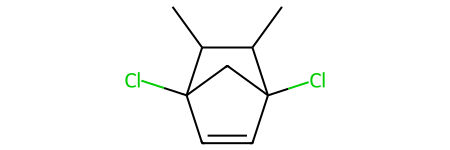

In [90]:
Chem.MolFromSmiles(out[1].split('>>')[1])

In [188]:
id_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639]

In [189]:
import pandas as pd

umatches_smiles = []

idx = 0
df = pd.read_csv('/home/ruard/Downloads/test_da_reactions_new_new.csv')
for i in range(len(df)):
    if i not in id_list:
        idx += 1
        umatches_smiles.append((
            i, df['reaction_smiles'].values[i]
        ))

In [22]:
Chem.MolFromSmiles(umatches_smiles[90][1].split('>>')[1])

IndexError: list index out of range

In [23]:
wrong_values[110]

NameError: name 'wrong_values' is not defined

In [24]:
len(umatches_smiles)

64

In [190]:
import cairosvg
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions

mols = [Chem.MolFromSmiles(val[1].split('>>')[1]) for val in umatches_smiles]

for i, mol in enumerate(mols):
    Draw.MolToFile(mol, "temp.svg")
    cairosvg.svg2png(url='temp.svg', write_to=f"/home/ruard/Pictures/mols/{i}.png" )


In [129]:
umatches_smiles[21][1]

'C1=CCC=C1.C[13C]1=[13CH]C(=O)C(Cl)=C(Cl)C1=O>>C[13C]12C(=O)C(Cl)=C(Cl)C(=O)[13CH]1C1C=CC2C1'

In [86]:
out = get_core_reaction_from_smiles(umatches_smiles[203][1])
out

IndexError: list index out of range

In [126]:
# reaction_smiles = "C=C=CC=C.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>C=CC=C1CC2(Cl)C(Cl)=C(Cl)C1(Cl)C2(OC)OC"
# reaction_smiles = "C=C=CC=C.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>C=C1C=CCC2(Cl)C(OC)(OC)C(Cl)=C(Cl)C12Cl"
reaction_smiles = "C=C=CC=C.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>C=CC1C(=C)C2(Cl)C(Cl)=C(Cl)C1(Cl)C2(OC)OC"
# reaction_smiles = "C=C=CC=C.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>C=C=CC1CC2(Cl)C(Cl)=C(Cl)C1(Cl)C2(OC)OC"
# reaction_smiles = "C=C=CC=C.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>C=C1C=CCC2(Cl)C(Cl)=C(Cl)C(OC)(OC)C12Cl"

# reaction_smiles = "C1=CC2(CC2)C(COCc2ccccc2)=C1.C=C(Cl)C#N>>N#CC1(Cl)CC2(COCc3ccccc3)C=CC1C21CC1"
# reaction_smiles = "C1=CC2(CC2)C(COCc2ccccc2)=C1.C=C(Cl)C#N>>N#CC1(Cl)CC2C=CC1(COCc1ccccc1)C21CC1"

out = get_core_reaction_from_smiles(reaction_smiles)
print(out)

[]


In [127]:
Chem.MolFromSmiles(out[0].split('>>')[-1])

IndexError: list index out of range

In [128]:
Chem.MolFromSmiles(out[0].split('>>')[0])

IndexError: list index out of range